In [ ]:
#Analysing the sentiment on songs that has released durin COVID-19 using en-sentiment pre-trained moedel
#importing all recquired packages
import re
import nltk
import string
import pandas as pd
import numpy as np
from nltk import bigrams
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM, concatenate
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D

In [ ]:
import nltk
nltk.download('punkt')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import nltk
nltk.download('wordnet')

import nltk
nltk.download('omw-1.4')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_csv('spotify_songs_sample.csv')
#df = pd.read_csv('/content/drive/MyDrive/spotify_songs_sample.csv')

In [ ]:
df = df[['lyrics', 'valence', 'track_album_release_date']]

print(df.columns)

Index(['lyrics', 'valence', 'track_album_release_date'], dtype='object')


changing the name of 'track_album_release_date' to 'year'

In [ ]:

df.rename(columns={'track_album_release_date': 'year'}, inplace=True)

In [ ]:
#Extracting Year from Different Date Formats in Python
date_pattern = r'^\d{1,2}/\d{1,2}/\d{4}$'
year_pattern = r'^\d{4}$'

def format_date(date_str):
    if re.match(date_pattern, date_str):
        return date_str[-4:]
    elif re.match(year_pattern, date_str):
        return date_str
    else:
        return None

In [ ]:
df['year'] = df['year'].apply(format_date)

In [ ]:
#Exploratory data analysis
df.isnull().sum()

lyrics     260
valence      0
year        25
dtype: int64

<Axes: >

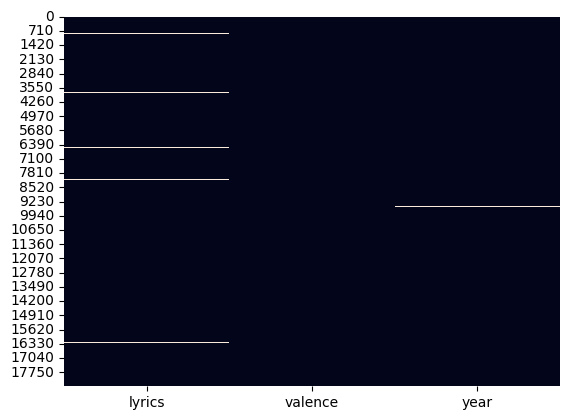

In [ ]:
#Visualizing Missing Data in the DataFrame using Seaborn's Heatmap
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

#In this heatmap, the dark color represents the missing values. Each column is represented on the x-axis, and the rows of the data on the y-axis.

<Axes: >

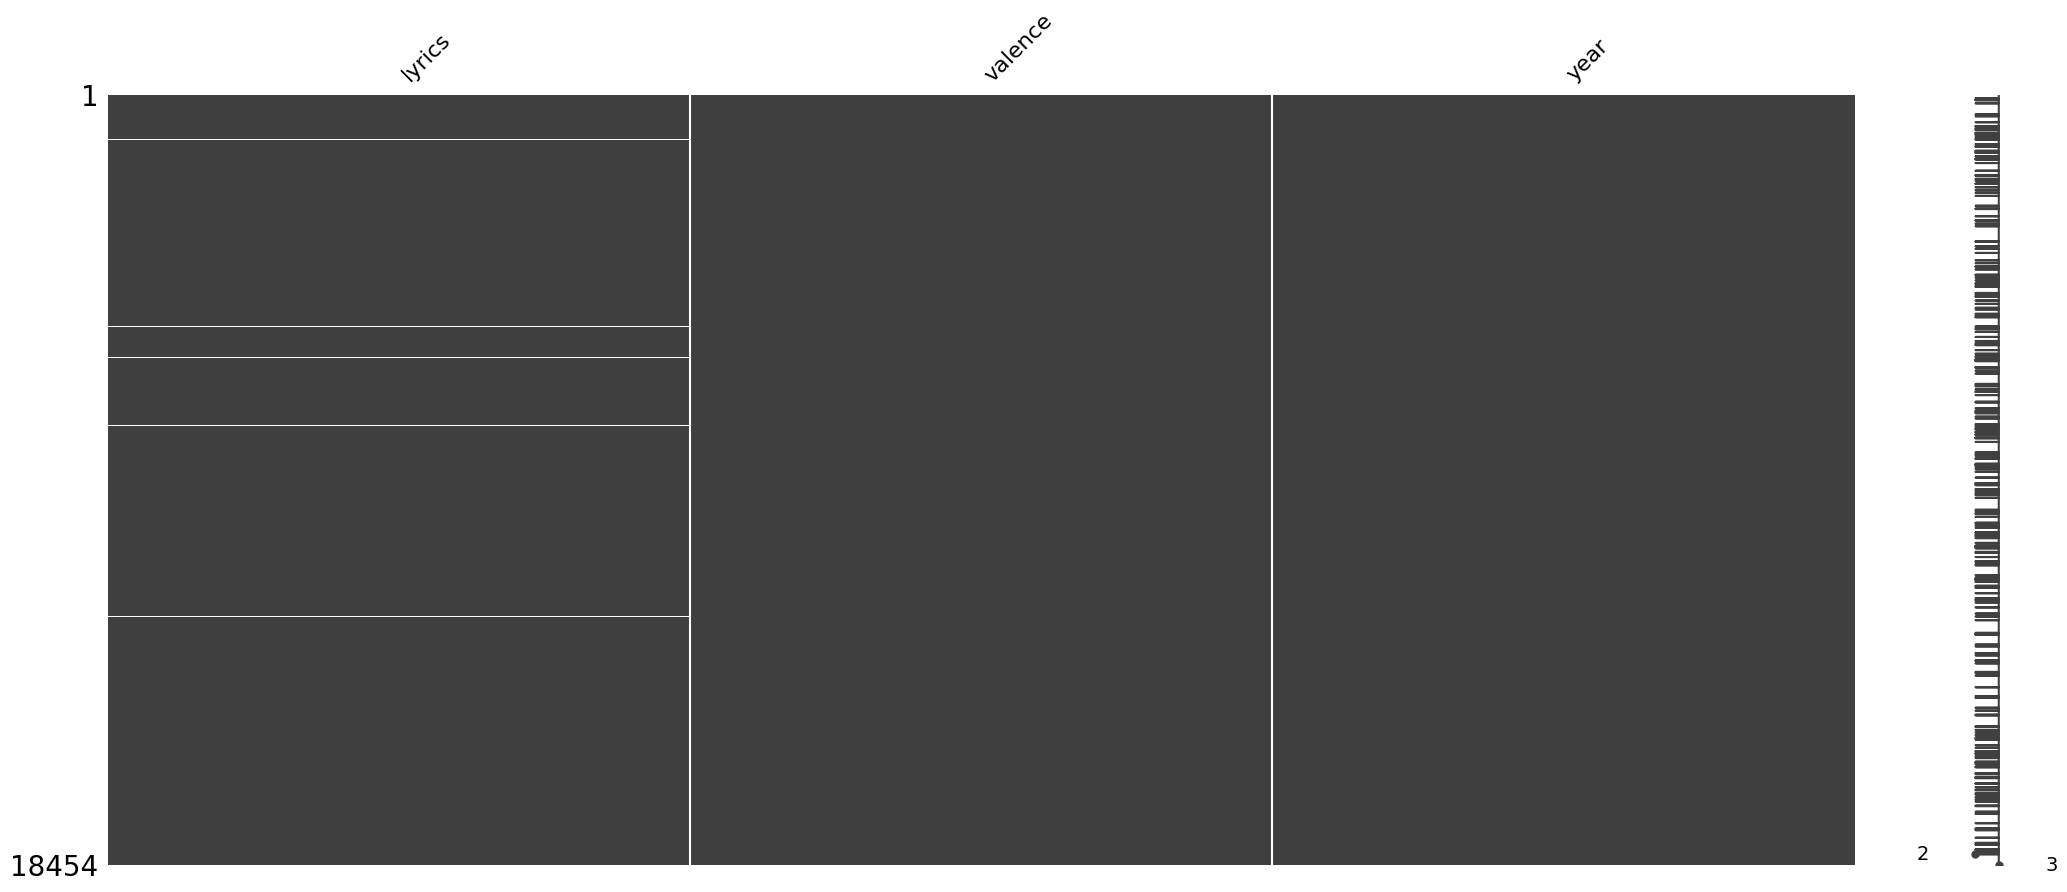

In [ ]:
#Visualizing Missing Data Distribution in the DataFrame using Missingno's Matrix Plot
import missingno as msno
msno.matrix(df)

#In the Missingno matrix plot, the sparkline on the right gives an idea of the general shape of the completeness of the data and points out the rows with the maximum and minimum nullity in the dataset.

<Axes: >

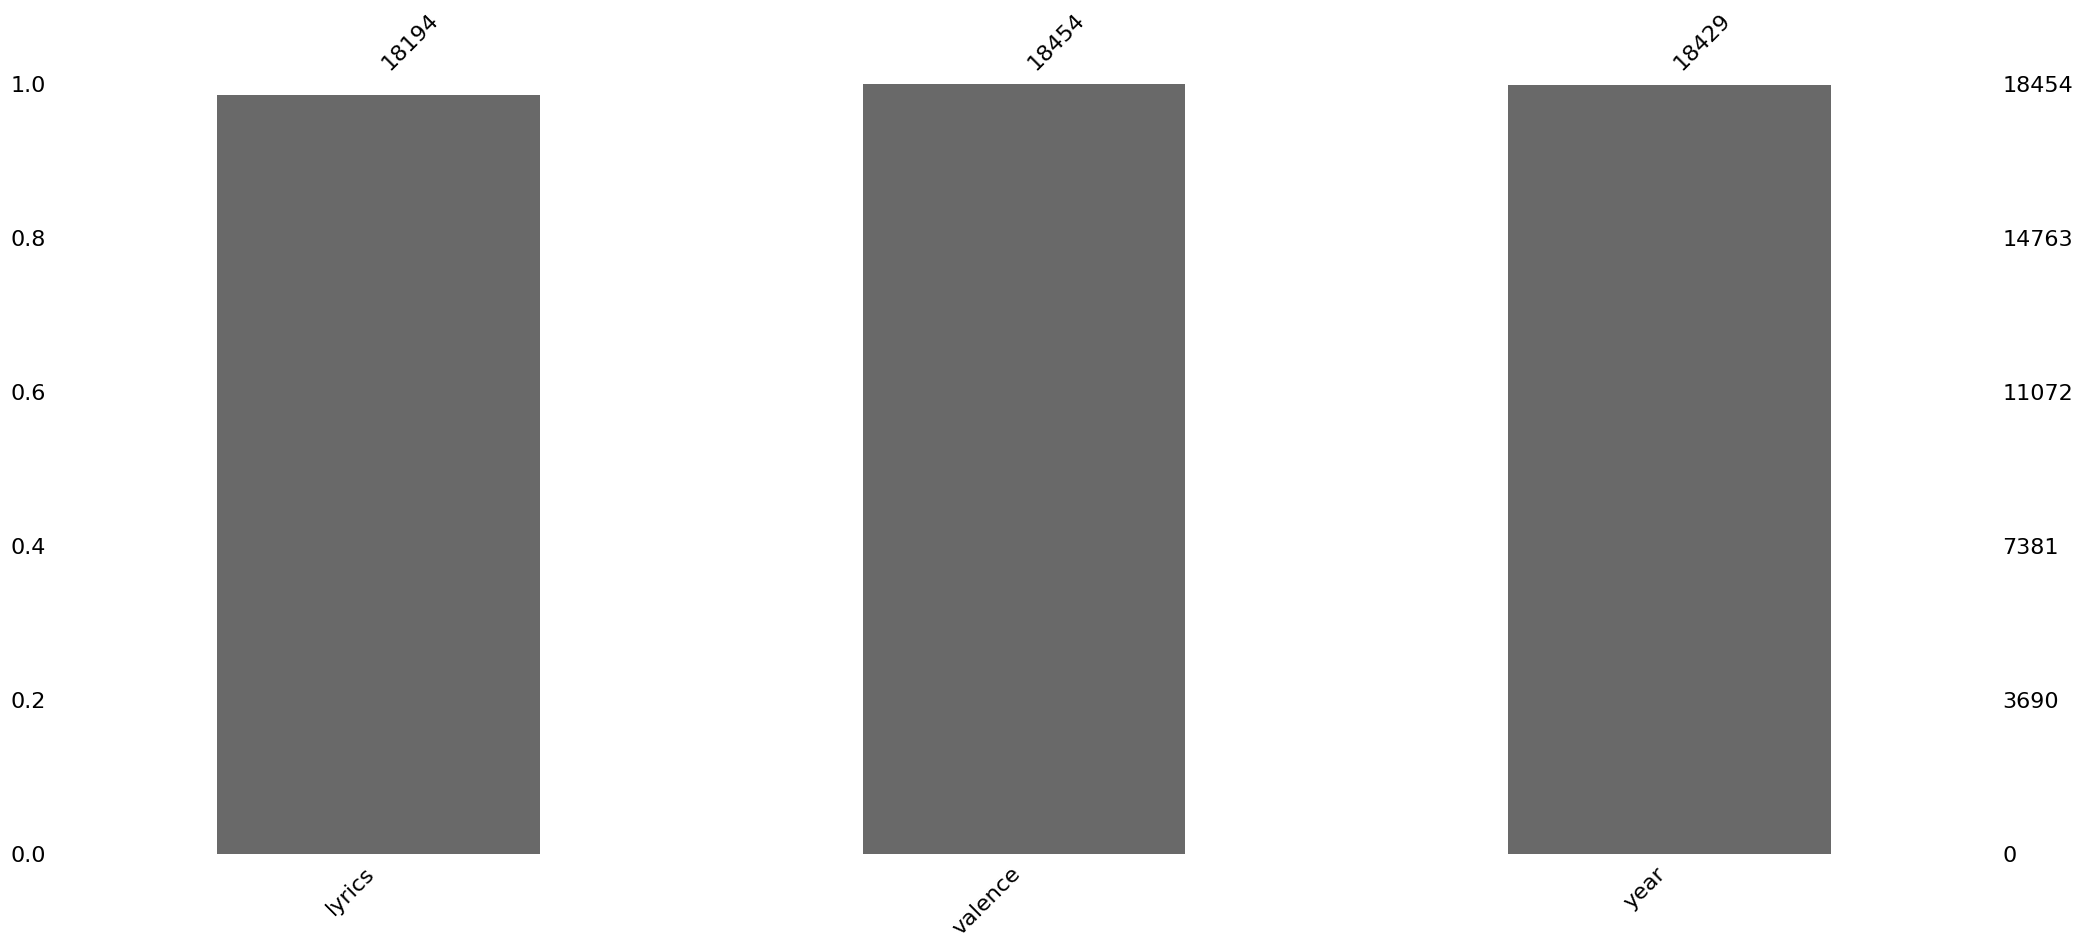

In [ ]:
msno.bar(df)

In [ ]:
# Droping rows with null values in the 'lyrics' column
df = df.dropna(subset=['lyrics'])
# Droping rows with null values in the 'lyrics' column
df = df.dropna(subset=['valence'])
# Droping rows with null values in the 'lyrics' column
df = df.dropna(subset=['year'])

In [ ]:
df['year'] = df['year'].astype(int)

In [ ]:
# converting the valence column to categorical labels
df['valence_cat'] = pd.cut(df['valence'], bins=[-1, 0.5, 1], labels=['negative', 'positive'])

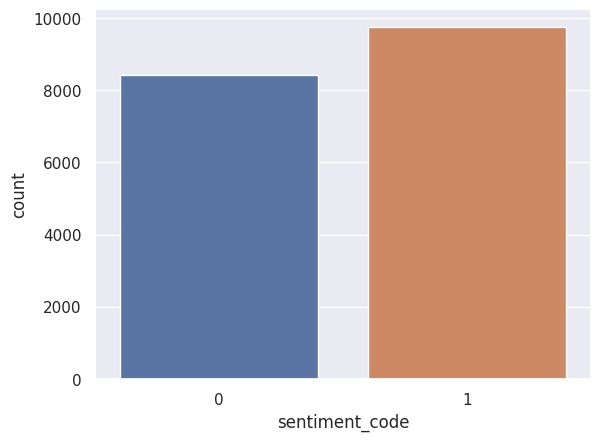

In [ ]:
#Plotting Sentiment Distribution in the Dataset using Seaborn's Countplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Assign numerical codes to sentiment values
sentiment_codes = {"negative": 0, "positive": 1}
df["sentiment_code"] = df["valence_cat"].map(sentiment_codes)
# Create a countplot with the sentiment codes
sns.countplot(x="sentiment_code", data=df)
plt.show()

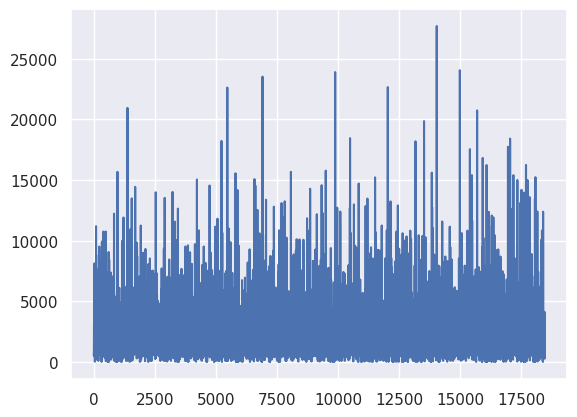

In [ ]:
#Visualizing the Length of Lyrics in the Dataset using Matplotlib's Line Plot
df['Length'] = df.lyrics.apply(lambda x:len(x))
plt.plot(df.Length)
plt.show()

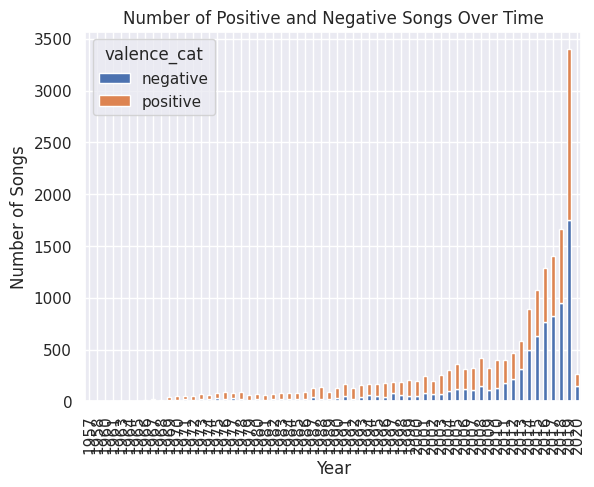

In [ ]:
#Visualizing the Distribution of Positive and Negative Songs Over Years using a Stacked Bar Chart

df['year'] = df['year'].astype(int)
df_yearly = df.groupby(['year', 'valence_cat']).size().reset_index(name='counts')

# Pivoting the table to make it suitable for plotting
df_yearly_pivot = df_yearly.pivot(index='year', columns='valence_cat', values='counts')

# Replacing NaN values with 0
df_yearly_pivot = df_yearly_pivot.fillna(0)


df_yearly_pivot.plot(kind='bar', stacked=True)
plt.title('Number of Positive and Negative Songs Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.show()

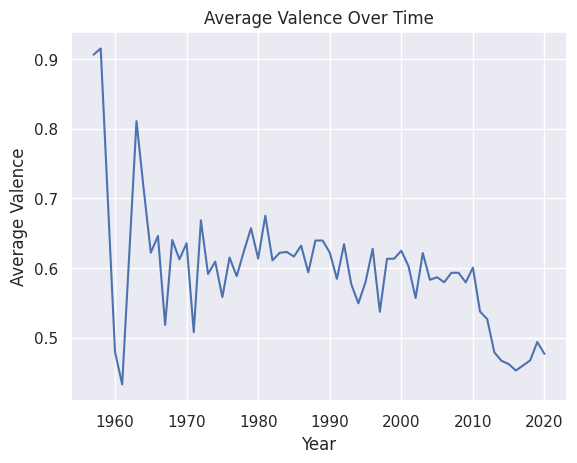

In [ ]:
#Visualizing the Trend of Average Valence in Songs Over Years using a Line Plot
# Grouping by year and calculating the mean valence
df_valence_yearly = df.groupby('year')['valence'].mean().reset_index()

# Ploting the data
plt.plot(df_valence_yearly['year'], df_valence_yearly['valence'])
plt.title('Average Valence Over Time')
plt.xlabel('Year')
plt.ylabel('Average Valence')
plt.show()

In [ ]:
#Function to Extract Most Common Words from Song Lyrics Based on Valence Category using NLTK

from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

def get_most_common_words(df, valence, n=10):
    # Filter the dataframe based on valence
    df_valence = df[df['valence_cat'] == valence]

    # Combine all the lyrics into one string
    all_lyrics = ' '.join(df_valence['lyrics'])

    # Tokenize the lyrics
    tokenized_lyrics = word_tokenize(all_lyrics)

    # Create a frequency distribution
    freq_dist = FreqDist(tokenized_lyrics)

    # Get the n most common words
    most_common_words = freq_dist.most_common(n)

    return most_common_words

In [ ]:
#Finding the Most Common Words in Positive and Negative Songs using get_most_common_words Function
# Get the most common words in positive songs
positive_words = get_most_common_words(df, 'positive', 10)
print("Positive words: ", positive_words)

# Get the most common words in negative songs
negative_words = get_most_common_words(df, 'negative', 10)
print("Negative words: ", negative_words)

Positive words:  [(',', 345698), ('I', 188211), ('you', 124514), ('the', 114770), ('me', 82251), ('(', 81123), (')', 81117), ('a', 75432), ("'", 70425), ('to', 68599)]
Negative words:  [(',', 257484), ('I', 165923), ('you', 104154), ('the', 93064), ('me', 61550), ('(', 55027), (')', 55023), ('to', 54130), ('a', 52609), ('it', 50477)]


In [ ]:
#Extracting and Displaying Most Common Bi-grams and Tri-grams in Positive and Negative Songs using a Custom Function 'get_most_common_ngrams'
def get_most_common_ngrams(df, n, valence, top=10):
    # Filter the dataframe based on valence
    df_valence = df[df['valence_cat'] == valence]

    # Combine all the lyrics into one string
    all_lyrics = ' '.join(df_valence['lyrics'])

    # Tokenize the lyrics
    tokenized_lyrics = word_tokenize(all_lyrics)

    # Generate n-grams
    n_grams = list(nltk.ngrams(tokenized_lyrics, n))

    # Get the most common n-grams
    most_common_ngrams = Counter(n_grams).most_common(top)

    return most_common_ngrams

# Get the most common bigrams in positive songs
positive_bigrams = get_most_common_ngrams(df, 2, 'positive', 10)
print("Positive bigrams: ", positive_bigrams)

# Get the most common bigrams in negative songs
negative_bigrams = get_most_common_ngrams(df, 2, 'negative', 10)
print("Negative bigrams: ", negative_bigrams)

# Get the most common trigrams in positive songs
positive_trigrams = get_most_common_ngrams(df, 3, 'positive', 10)
print("Positive trigrams: ", positive_trigrams)

# Get the most common trigrams in negative songs
negative_trigrams = get_most_common_ngrams(df, 3, 'negative', 10)
print("Negative trigrams: ", negative_trigrams)


Positive bigrams:  [(('I', "'m"), 39889), ((',', 'I'), 28990), (('do', "n't"), 21215), (('in', 'the'), 12175), ((',', 'you'), 12083), ((',', 'yeah'), 12029), (('it', "'s"), 11516), (('wan', 'na'), 11226), (('ca', "n't"), 10164), (('I', 'do'), 9892)]
Negative bigrams:  [(('I', "'m"), 35031), ((',', 'I'), 27135), (('do', "n't"), 18460), ((',', 'yeah'), 10222), (('in', 'the'), 9876), (('I', 'do'), 9748), (('it', "'s"), 9452), ((',', 'you'), 9274), (('wan', 'na'), 9062), (('ca', "n't"), 7750)]
Positive trigrams:  [(('I', 'do', "n't"), 7879), ((',', 'I', "'m"), 7508), (('I', 'ca', "n't"), 4655), ((',', 'yeah', ','), 4150), (('I', 'wan', 'na'), 3836), ((',', 'it', "'s"), 3689), ((',', 'oh', ','), 3204), ((',', 'do', "n't"), 2883), (('I', 'ai', "n't"), 2805), (('yeah', ',', 'yeah'), 2760)]
Negative trigrams:  [(('I', 'do', "n't"), 8181), ((',', 'I', "'m"), 6639), (('I', 'ca', "n't"), 4075), ((',', 'oh', ','), 3626), ((',', 'yeah', ','), 3316), ((',', 'it', "'s"), 2827), (('I', 'wan', 'na'), 2

In [ ]:
#Preprocessing Song Lyrics by Removing Punctuation, Lowercasing, Removing Numbers, Tokenizing, Removing Stop Words, and Lemmatizing using NLTK
import string
def preprocess_text(text):
    if text is None or text != text or text.strip() == "":
        return ""
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    text = nltk.word_tokenize(text.lower())
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

df['lyrics'] = df['lyrics'].apply(lambda x: preprocess_text(x))

In [ ]:
from nltk import bigrams
from collections import Counter
#Extracting and Displaying Most Common Bi-grams and Tri-grams in Preprocessed Positive and Negative Song Lyrics using get_most_common_ngrams Function after preprocessing
def get_most_common_ngrams(df, n, valence, top=10):
    # Filter the dataframe based on valence
    df_valence = df[df['valence_cat'] == valence]

    # Combine all the lyrics into one string
    all_lyrics = ' '.join(df_valence['lyrics'])

    # Tokenize the lyrics
    tokenized_lyrics = word_tokenize(all_lyrics)

    # Generate n-grams
    n_grams = list(nltk.ngrams(tokenized_lyrics, n))

    # Get the most common n-grams
    most_common_ngrams = Counter(n_grams).most_common(top)

    return most_common_ngrams

# Get the most common bigrams in positive songs
positive_bigrams = get_most_common_ngrams(df, 2, 'positive', 10)
print("Positive bigrams: ", positive_bigrams)

# Get the most common bigrams in negative songs
negative_bigrams = get_most_common_ngrams(df, 2, 'negative', 10)
print("Negative bigrams: ", negative_bigrams)

# Get the most common trigrams in positive songs
positive_trigrams = get_most_common_ngrams(df, 3, 'positive', 10)
print("Positive trigrams: ", positive_trigrams)

# Get the most common trigrams in negative songs
negative_trigrams = get_most_common_ngrams(df, 3, 'negative', 10)
print("Negative trigrams: ", negative_trigrams)


Positive bigrams:  [(('wan', 'na'), 11633), (('gon', 'na'), 7764), (('oh', 'oh'), 7485), (('yeah', 'yeah'), 5912), (('got', 'ta'), 4765), (('na', 'na'), 3424), (('la', 'la'), 3412), (('dont', 'know'), 3136), (('lo', 'que'), 3041), (('let', 'go'), 2931)]
Negative bigrams:  [(('wan', 'na'), 9365), (('oh', 'oh'), 5973), (('gon', 'na'), 5095), (('yeah', 'yeah'), 4512), (('got', 'ta'), 3149), (('let', 'go'), 2853), (('dont', 'know'), 2813), (('love', 'love'), 2247), (('dont', 'wan'), 2174), (('la', 'la'), 1917)]
Positive trigrams:  [(('oh', 'oh', 'oh'), 4248), (('yeah', 'yeah', 'yeah'), 2926), (('la', 'la', 'la'), 2728), (('na', 'na', 'na'), 2615), (('im', 'gon', 'na'), 2016), (('dont', 'wan', 'na'), 1957), (('ooh', 'ooh', 'ooh'), 1451), (('love', 'love', 'love'), 1329), (('work', 'work', 'work'), 836), (('come', 'come', 'come'), 814)]
Negative trigrams:  [(('oh', 'oh', 'oh'), 3661), (('yeah', 'yeah', 'yeah'), 2170), (('dont', 'wan', 'na'), 2160), (('la', 'la', 'la'), 1548), (('im', 'gon', 

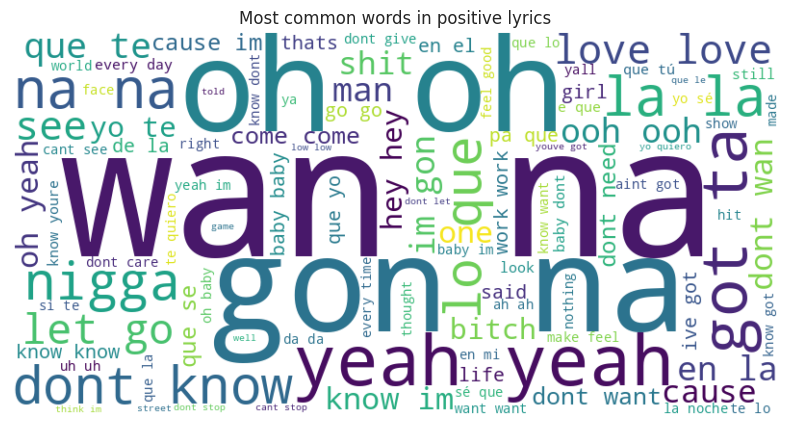

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#Generating a Word Cloud for Most Common Words in Positive Lyrics and Negative Lyrics
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Combine all the lyrics into one string for positive and negative valence
positive_lyrics = ' '.join(df[df['valence_cat'] == 'positive']['lyrics'])
negative_lyrics = ' '.join(df[df['valence_cat'] == 'negative']['lyrics'])

# Plot word clouds
plot_wordcloud(positive_lyrics, 'Most common words in positive lyrics')


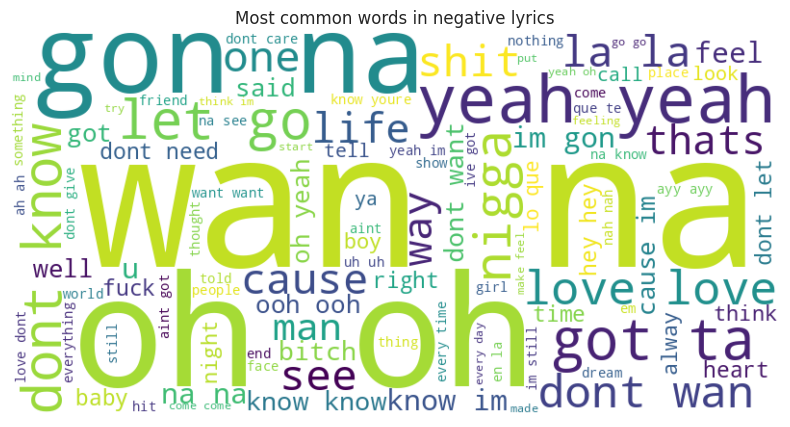

In [ ]:
plot_wordcloud(negative_lyrics, 'Most common words in negative lyrics')

In [ ]:
# Splitting the Dataset into Training and Test Sets Based on Year
train_data = df[df['year'] < 2019]
test_data = df[df['year'] >= 2019]

In [ ]:
train_data.count()

lyrics            14508
valence           14508
year              14508
valence_cat       14508
sentiment_code    14508
Length            14508
dtype: int64

In [ ]:
test_data.count()

lyrics            3661
valence           3661
year              3661
valence_cat       3661
sentiment_code    3661
Length            3661
dtype: int64

In [ ]:
# convert the valence column to categorical labels for test_set
test_data['valence_cat'] = pd.cut(test_data['valence'], bins=[-1, 0.5, 1], labels=['negative', 'positive'])

<ipython-input-38-310d0c970eb2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['valence_cat'] = pd.cut(test_data['valence'], bins=[-1, 0.5, 1], labels=['negative', 'positive'])


In [ ]:
# convert the valence column to categorical labels for train_set
train_data['valence_cat'] = pd.cut(train_data['valence'], bins=[-1, 0.5, 1], labels=['negative', 'positive'])

<ipython-input-39-707a3fc5fc80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['valence_cat'] = pd.cut(train_data['valence'], bins=[-1, 0.5, 1], labels=['negative', 'positive'])


In [ ]:
#Training a Tokenizer on Lyrics for Text Processing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['lyrics'])

In [ ]:
#Converting Lyrics into Sequences for Training and Testing Datasets using the Fitted Tokenizer
X_train = tokenizer.texts_to_sequences(train_data['lyrics'])
X_test = tokenizer.texts_to_sequences(test_data['lyrics'])

In [ ]:
col_lengths = df.apply(lambda x: len(x))

print(col_lengths)

lyrics            18169
valence           18169
year              18169
valence_cat       18169
sentiment_code    18169
Length            18169
dtype: int64


In [ ]:
#Padding Sequences for Training and Testing Datasets to a Fixed Length
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# convert the categorical labels to one-hot vectors

y_train = to_categorical(train_data['valence_cat'].replace({'positive': 1, 'negative': 0}))
y_test = to_categorical(test_data['valence_cat'].replace({'positive': 1, 'negative': 0}))

In [ ]:
#Building a Hybrid Deep Learning Model Using LSTM and GRU Layers with Dropout and L2 Regularization
#Model Building
from keras.layers import Dropout, Input, Embedding, LSTM, GRU, Dense
from keras.layers import concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Defining L2 regularizer
reg = l2(0.01)

# LSTM model with  dropout and L2 regularization
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(input_layer)
lstm_layer = LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=reg)(embedding_layer)
dropout_layer = Dropout(0.6)(lstm_layer)

# GRU model with  dropout and L2 regularization
input_layer2 = Input(shape=(max_len,))
embedding_layer2 = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(input_layer2)
gru_layer = GRU(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=reg)(embedding_layer2)
dropout_layer2 = Dropout(0.6)(gru_layer)

# Merging the two models
merged = concatenate([dropout_layer, dropout_layer2])
dense_layer = Dense(64, activation='relu', kernel_regularizer=reg)(merged)
output_layer = Dense(2, activation='softmax')(dense_layer)

# Defining the model
model = Model(inputs=[input_layer, input_layer2], outputs=output_layer)

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
  #Training the Hybrid Deep Learning Model on the Training Data with Early Stopping
  # Define early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)

  # Fit the model
  history = model.fit([X_train, X_train], y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
182/182 [==============================] - 201s 1s/step - loss: 1.6024 - accuracy: 0.5486 - val_loss: 0.7365 - val_accuracy: 0.5469
Epoch 2/10
182/182 [==============================] - 186s 1s/step - loss: 0.7113 - accuracy: 0.5514 - val_loss: 0.7022 - val_accuracy: 0.5469
Epoch 3/10
182/182 [==============================] - 202s 1s/step - loss: 0.6898 - accuracy: 0.5515 - val_loss: 0.6801 - val_accuracy: 0.5469
Epoch 4/10
182/182 [==============================] - 179s 984ms/step - loss: 0.6559 - accuracy: 0.6367 - val_loss: 0.6879 - val_accuracy: 0.6065
Epoch 5/10
182/182 [==============================] - 184s 1s/step - loss: 0.6060 - accuracy: 0.7196 - val_loss: 0.6922 - val_accuracy: 0.6223
Epoch 6/10
182/182 [==============================] - 209s 1s/step - loss: 0.5535 - accuracy: 0.7543 - val_loss: 0.6939 - val_accuracy: 0.6313
Epoch 7/10
182/182 [==============================] - 252s 1s/step - loss: 0.5189 - accuracy: 0.7802 - val_loss: 0.6775 - val_accuracy: 0.6

In [ ]:
# Evaluating the Hybrid Deep Learning Model on the Test Data
test_loss, test_acc = model.evaluate([X_test, X_test], y_test, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.8525604009628296
Test accuracy: 0.5730674862861633


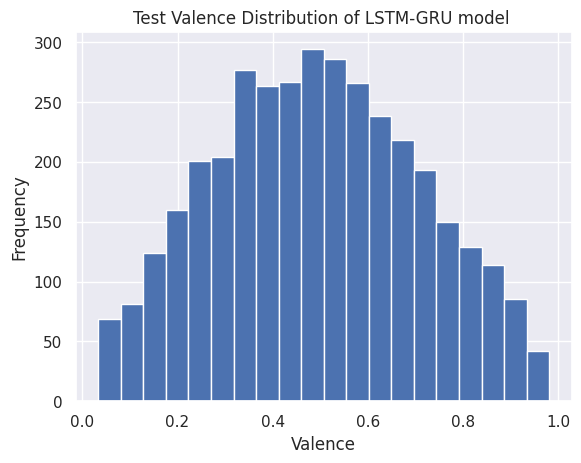

In [ ]:
#Visualizing the Valence Distribution of the Test Data using a Histogram
plt.hist(test_data['valence'], bins=20)
plt.title('Test Valence Distribution of LSTM-GRU model ')
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.show()

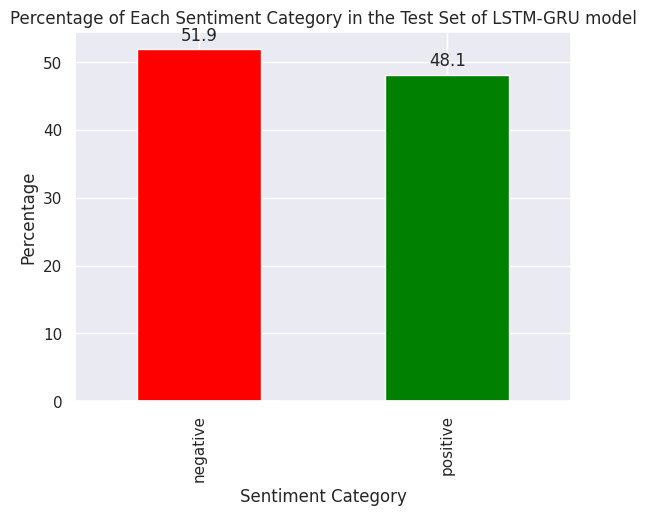

In [ ]:
# Visualizing the Percentage Distribution of Sentiment Categories in the Test Set of the LSTM-GRU Model using a Bar Chart
test_valence_counts = test_data['valence_cat'].value_counts(normalize=True) * 100


colors = ['green' if label == 'positive' else 'red' for label in test_valence_counts.index]

ax = test_valence_counts.plot(kind='bar', color=colors)
plt.title('Percentage of Each Sentiment Category in the Test Set of LSTM-GRU model')
plt.xlabel('Sentiment Category')
plt.ylabel('Percentage')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

plt.show()

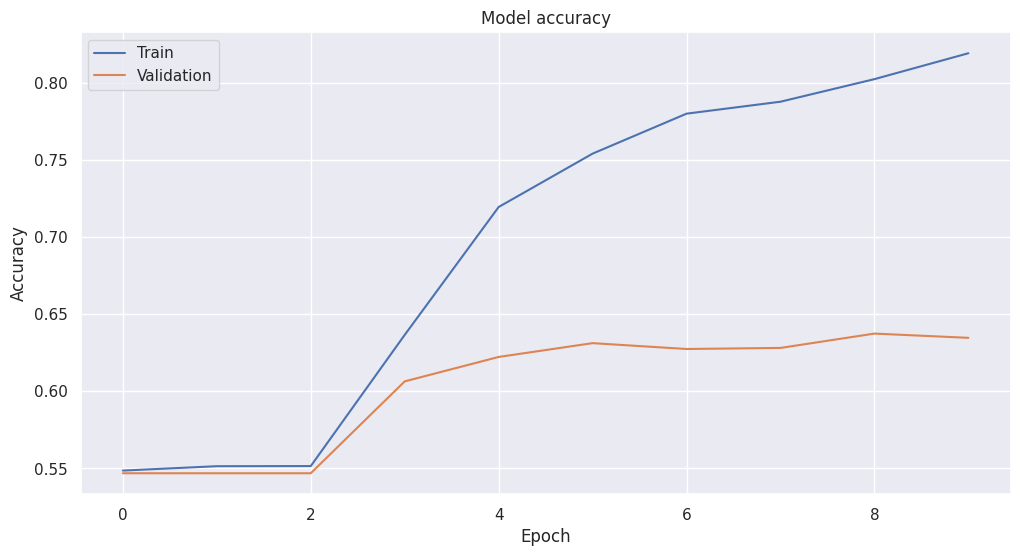

In [ ]:
#Visualizing the Training and Validation Accuracy over Epochs for the Hybrid Deep Learning Model
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

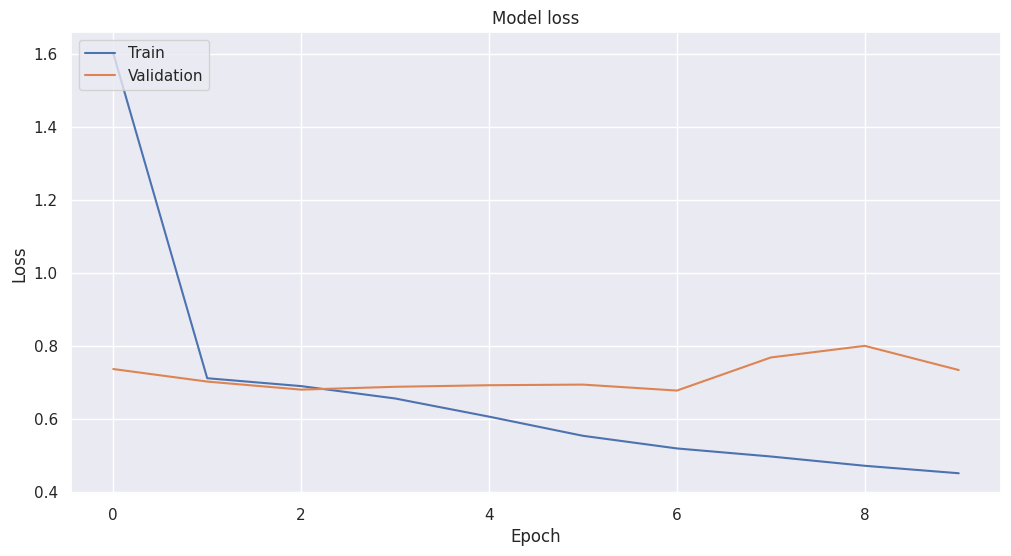

In [ ]:
# Visualizing the Training and Validation Loss over Epochs for the Hybrid Deep Learning Model
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

115/115 [==============================] - 7s 52ms/step


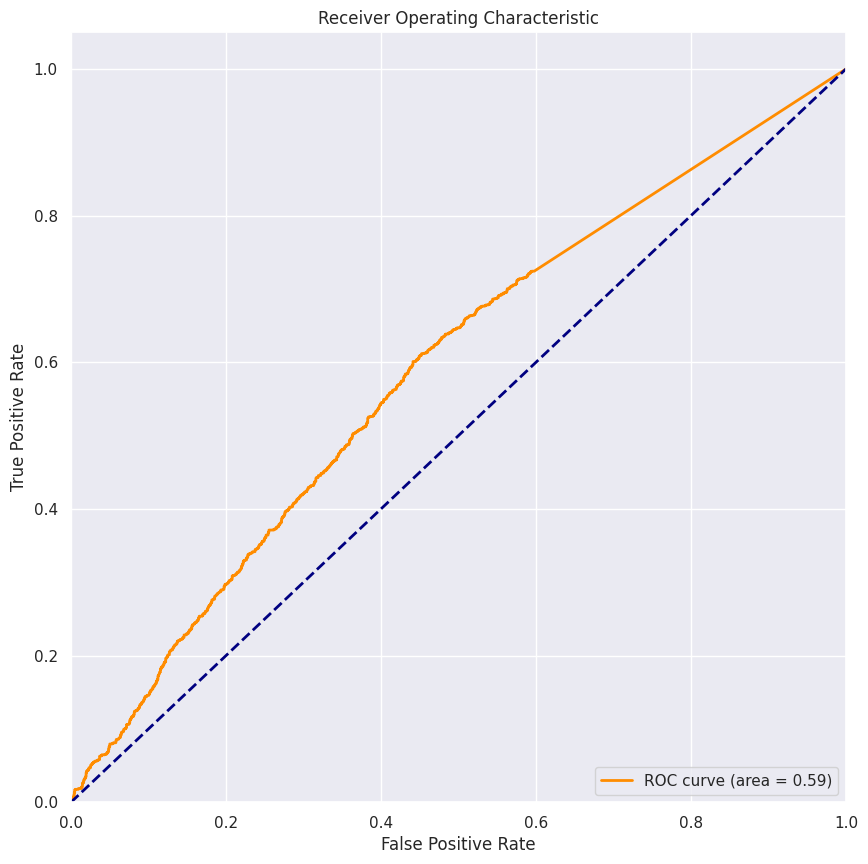

In [ ]:
#Visualizing the Receiver Operating Characteristic (ROC) Curve and Calculating the Area Under the Curve (AUC) for the Hybrid Deep Learning Model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predicting the probabilities for the positive class
y_pred_prob = model.predict([X_test, X_test])

# Calculating the ROC curve
fpr, tpr, thresholds = roc_curve(y_test.argmax(axis=1), y_pred_prob[:, 1])

# Calculating the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()